## Finding Donors for *CharityML*

## Description

In this project, we will employ several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. We will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Our goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. We can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
The code cell below loads necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [16]:
# Importing libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Importing supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Loading the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. The code cell below, computes the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

In [17]:
# Total number of records
n_records = len(data)

# Number of records where individual's income is more than $50,000
# n_greater_50k = len(data.loc[data['income'] == ">50K"])
n_greater_50k = data[data['income']=='>50K'].shape[0]

# Number of records where individual's income is at most $50,000
#n_at_most_50k = len(data.loc[data['income'] == "<=50K"])
#n_at_most_50k, n_greater_50k = data.income.value_counts()
n_at_most_50k = data[data['income']=='<=50K'].shape[0]

# Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k * 100) / n_records

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


**Featureset Exploration**

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

The code cell below plots a histogram of these two features. We can see the range of the values present and how they are distributed.

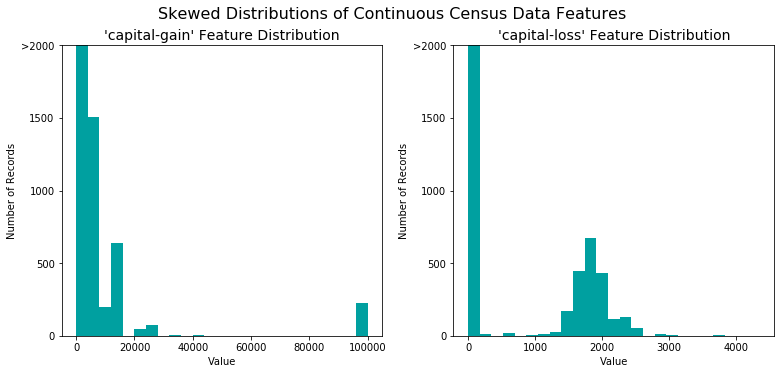

In [18]:
# Splitting the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualizing skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Tode cell below performs a transformation on the data and visualize the results. Again, we can see the range of values and how they are distributed. 

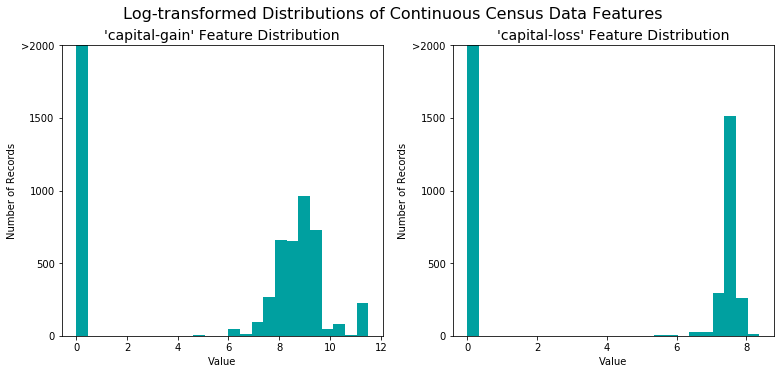

In [19]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualizing the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

The code cell below normalizes each numerical feature. [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) is used for this purpose.

In [20]:
# Importing sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initializing a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Showing an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

![alt text](images/one-hot.png)


Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. The code below uses [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data. It then convert the target label `'income_raw'` to numerical entries and sets records with "<=50K" to `0` and records with ">50K" to `1`.

In [31]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# TODO: Encode the 'income_raw' data to numerical values
income_tmp = pd.get_dummies(income_raw)
income = income_tmp['>50K'].values

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

print(income)

103 total features after one-hot encoding.
[0 0 0 ... 0 0 1]


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [22]:
# Importing train_test_split
from sklearn.model_selection import train_test_split

# Splitting the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Showing the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners , and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes -those who make at most \$50,000, and those who make more, it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for our data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Accuracy, precision, recall

**Accuracy** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

**Precision** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

**Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Note 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? We must use the code cell below and assign our results to `'accuracy'` and `'fscore'` to be used later.

**Note** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally our base model would be either the results of a previous model or could be based on a research paper upon which we are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place we could start from. 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score (True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [32]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# Calculating accuracy, precision and recall
TP = np.sum(income)
FP = income.size - TP
TN = 0
FN = 0

accuracy = TP / (TP + FP)
precision = TP / (TP + FP)
recall = TP / (TP + FN)

# Calculating F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta = 0.5
fscore = (1 + (beta ** 2)) * ((precision * recall)/(((beta ** 2) * precision) + recall))

# Print the results 
#print(accuracy, fscore)
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))
#print("Naive Predictor: [Accuracy score: %.4f, F-score: %.4f]" % (accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


### Note 2 - Supervised Learning Models
Below are a list three of the supervised learning models that seems to be appropriate for this problem that and we will test on the census data.

### Gaussian Naive Bayes:

Naive Bayes classifiers have worked quite well in many real-world situations, famously document classification and spam filtering. It also finds application in automatic medical diagnosis, categorizing news, face recognition, sentiment analysis, digit recognition and weather prediction.

Naive Bayes learners and classifiers can be extremely fast compared to more sophisticated methods. The decoupling of the class conditional feature distributions means that each distribution can be independently estimated as a one dimensional distribution. This in turn helps to alleviate problems stemming from the curse of dimensionality. Moreover these learners require a small amount of training data to estimate the necessary parameters.

Naive Bayes is generally known to be a bad estimator, so the probability outputs from predictions should be tested evaluated carefully.

Gaussian Naive Bayes uses normal distribution and it works well when training data contains continuous attributes such as what we have in this project. Moreover it is a fast algorithm. It also works well in classification problems so it might be a good option for finding the income class of a person.

References: 
[scikit-learn](http://scikit-learn.org/stable/modules/naive_bayes.html)
[wikipedia](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)
[quora](https://www.quora.com/In-what-real-world-applications-is-Naive-Bayes-classifier-used)


### Ensemble Methods - AdaBoost:


In terms of data, ensemble methods works well in imbalanced and noisy datasets, and concept-drift. In terms of application in real life, it is a great solution for the classification problems in malware and intrusion detection, banking, credit risk, fraud detection, coronary diseases, and recommender systems.

The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator. So we can use some basic or week learners and combine them to come up with a more robust ensemble learning. In general it is a more flexible machine learning algorithm as it allows to customize the way the learning mechanism works. Ada-boost in particular  directly optimizes the cost function and is often the best possible model.

Ada boost is not robust against outliers and noise and can overfit. In practice it usually needs several hyper-parameters. Moreover it lacks transparency due to the complexity of multiple trees.

It is a flexible method so considering the fact that we have several features in this project, in might be a good idea to use ensemble of learners to increase the chance of reaching a reliable solution by having our learner to learn on repeatedly modified versions of the census data.

References:
[scikit-learn](http://scikit-learn.org/stable/modules/ensemble.html)
[sciencedirect](https://www.sciencedirect.com/science/article/pii/S156625351300047X)
[datasciencecentral](https://www.datasciencecentral.com/profiles/blogs/want-to-win-at-kaggle-pay-attention-to-your-ensembles)

### SVM:


SVMs can be used to solve various real world problems such as text and hypertext categorization. Classification of images, handwritten character recognition, and also biological classifications.

The advantages of support vector machines are:
- Effective in high dimensional spaces.
- Still effective in cases where number of dimensions is greater than the number of samples.
- Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.
- Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.

The disadvantages of support vector machines include:
- If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.
- SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation.

SVM is being widely used in the classification problems and it is a good candidate as in our problem we need to predict a 2-class classification. Moreover, SVMs can efficiently perform a non-linear classification. Since we are dealing with several features, the best possible fit might be a non-linear classification so using SVM seems to be promising.

References:
[scikit-learn](http://scikit-learn.org/stable/modules/ensemble.html)
[wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine)

###### Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model we've chosen, it's important that we create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Our implementation here will be used in the following section.
The code block below, implements the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fits the learner to the sampled training data and records the training time.
 - Performs predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Records the total prediction time.
 - Calculates the accuracy score for both the training subset and testing set.
 - Calculates the F-score for both the training subset and testing set.
   - It also sets the `beta` parameter!

In [24]:
# Importing two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    

    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    
    end = time() # Get end time
    
    # Calculating the training time
    results['train_time'] = end - start
        
    # Geting the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    
    end = time() # Get end time
    
    # Calculating the total prediction time
    results['pred_time'] = end - start
            
    # Computing accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train[:300])
    
    # Computing accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,  predictions_test)
    
    # Computing F-score on the 
    the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train[:300], average='binary', beta=0.5)
        
    # TComputing F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, average=None, beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size)) 
    # Return the results
    return results

### Initial Model Evaluation
The code cell below, implements the following:
- Imports the three supervised learning models we've discussed in the previous section.
- Initializes the three models and stores them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Uses a `'random_state'` for each model we use, if provided.
  - Uses the default settings for each model — we will tune one specific model in a later section.
- Calculates the number of records equal to 1%, 10%, and 100% of the training data.
  - Stores those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.


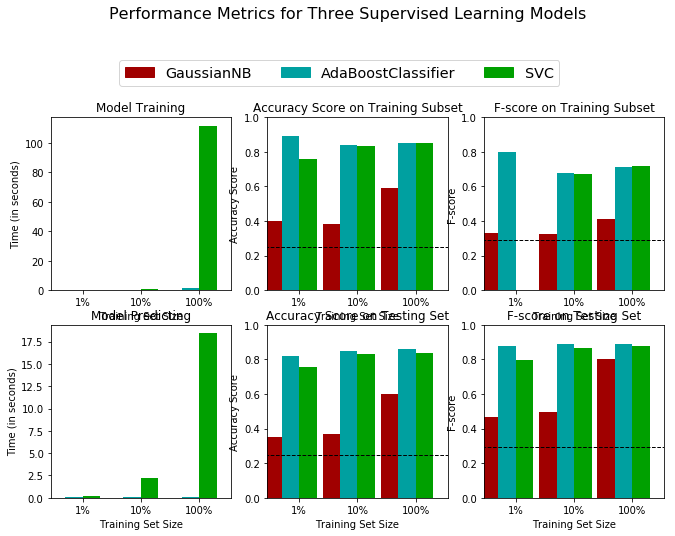

In [26]:
# Importing the three supervised learning models from sklearn
import warnings
# ignoring plot optimization and f1-score fit warnings
warnings.filterwarnings('ignore')
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm

# Initializing the three models
clf_A = GaussianNB()
clf_B = AdaBoostClassifier(random_state=10)
clf_C = svm.SVC(random_state=10)
#clf_C = svm.SVC(kernel='rbf', gamma=27)

# Calculating the number of samples for 1%, 10%, and 100% of the training data
# Note: samples_100 is the entire training set i.e. len(y_train)
# Note: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# Note: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int((len(y_train) * 10) / 100)
samples_1 = int((len(y_train) * 1) / 100)

# Collecting results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)
        

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, we will choose from the three supervised learning models the *best* model to use on the study data. We will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Note 3 - Choosing the Best Model

By a quick look at the F-score on Testing set it is obvious that AdaBoost classifier performs better when 1%, 10%, and 100% of the training set are used. It is also fast and doesn't take much time compare to the other models and has a relatively sustainable results over different proportions of the datasets.

Even though SVM has a high F-score and sustainability over three sets, it is slow. Particularly when 100% of the data is being used it takes more than 3 minutes for the model to train and more than 2 minutes to predict the income for the testing inputs.

GaussianNB is very fast but it doesn't have a good F-score so it's not a reliable model. Also its performance is not sustainable in the three sets as it performed very poorly when 1% and 10% of the data was used.

In a nutshell, the AdaBoost is the best classifier among the three which is used in this project and we can recommend CharityML to use this model!

### Note 4 - Describing the Model (in Layman's Terms)

The final selected model which is AdaBoost is an ensemble learning algorithm. That means, our algorithm consists of some small and different algorithms (weak learners) which collectively work together to solve the problem which we asked the algorithm to solve.  These small algorithm can be any learning algorithms. In the case of this project, they are decision trees. The way these small algorithms works together are as follows:

We first train our first algorithm to learn the data. That mean we let our algorithm to look at the data and try to find a prediction model based on the data which fit the data best. In another words our algorithm tries to propose a model that makes the minimum amount of mistakes when it tries to make a prediction. We then have the second algorithm to try to come up with another solution for the problem with a focus on fixing the mistakes that our first algorithm made. It does it by assigning more weights (penalty) to the mis-classified data points. We continue this process until all of our algorithms come up with the best solutions that they can.  Then we calculate The weight of each model using natural logarithmic. Finally for each data point we have all models to vote (by using their weights) and decide which class each data point belongs to. Eventually we combine all the vote for each data point to determine the final class which it belongs to.

The final model is now a boosted algorithm which can do much better than any individual small algorithms.

### Model Tuning
Now we fine tune the chosen model. We use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. We will need to use the entire training set for this. IThe code cell below implements the following:
- Imports [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initializes the classifier we've chosen and stores it in `clf`.
 - Sets a `random_state` if one is available to the same state we set before.
- Creates a dictionary of parameters we wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** It avoied tuning the `max_features` parameter of our learner if that parameter is available!
- Uses `make_scorer` to creates an `fbeta_score` scoring object (with $\beta = 0.5$).
- Performs grid search on the classifier `clf` using the `'scorer'`, and stores it in `grid_obj`.
- Fits the grid search object to the training data (`X_train`, `y_train`), and stores it in `grid_fit`.

In [27]:
# Importing 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn import grid_search
from sklearn.metrics import make_scorer
# Initializing the classifier
clf = AdaBoostClassifier(random_state=10)

# Creates the parameters list we wish to tune
# parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'learning_rate': [0.01, 0.1, 1, 10], 'n_estimators': [50, 100, 200]}
"""
parameters = {'learning_rate': [0.01, 0.1, 1, 10], 'base_estimator': ['DecisionTreeClassifier', 'svm.SVC'],\
              'n_estimators': [50, 100, 200], 'algorithm': ['SAMME', 'SAMME.R']}
"""

# Making an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Performing grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = grid_search.GridSearchCV(estimator=clf, param_grid=parameters, scoring=scorer)

# Fitting the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Getting the estimator
best_clf = grid_fit.best_estimator_

# Making predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8651
Final F-score on the testing data: 0.7396


### Note 5 - Final Model Evaluation

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |      0.8576       |      0.8651     |
| F-score        |      0.7246       |      0.7396     |


The accuracy of the optimized model is better than unoptimized model and compare to the naive predictor, the model's performance is much better as the accuracy score and f-score are 0.8651 and 0.7396 for the optimized model, and respectively 0.2478 and 0.2917 for the naive predictor.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

To do so, we choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell we fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Note 6 - Feature Relevance Observation
Before using scikit-learn, we can explore the dataset and "guess" which of the thirteen features, are the most important for prediction and in what order.

1. **capital gain:** The more capital gain usually suggests a high income.
2. **education:** The better education each individual has means they have probably a better chance to get a more professional job and consequently they will probably get a higher salary.
3. **work class:** Some work classes such as Private usually have better incomes.
4. **age:** The higher the age usually means people have gained more capital gain, promoted to a higher salary rate, and have a higher income.
5. **occupation:** Some specific occupation categories such as excecutives requires higher and complicated skills. People in those categories usually have better incomes.

### Extracting Feature Importance
The code cell below, implements the following:
 - Chooses a AdaBoostClassifier learning model for our purpose.
 - Trains this supervised model on the entire training set.
 - Extracst the feature importances using `'.feature_importances_'`.

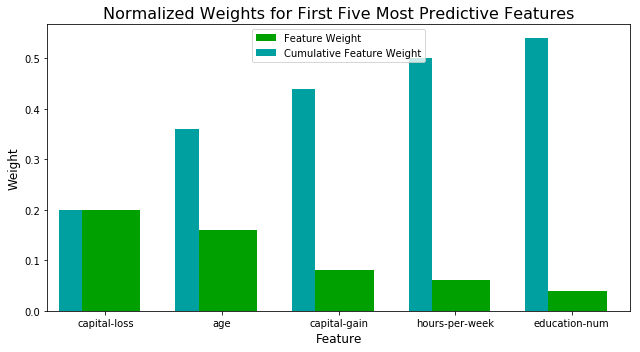

In [28]:
# Training the supervised model on the training set using .fit(X_train, y_train)
model = AdaBoostClassifier(random_state=10)
model = model.fit(X_train, y_train)

# Extracting the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plotting
vs.feature_plot(importances, X_train, y_train)

### Note 7 - Extracting Feature Importance

We can see that the important "age" and "capital-gain" feature were in our initial guess list too. However we were thinking that capital gain had more impact as we ranked it first.

However we selected education level, the feature_importances_ believes the number of education years is a more importance factor for income in compare to the education level. Maybe that's because the more education years means not only the higher chance to reach a better education level but also gaining higher skills which bring more income.

The diagram also shows the the capital-loss is a very important factor which is interesting to since we didn't think so initially. Maybe for those with lower capital-loss the main reason for losing capital was having a low income!

Now when we re-think, that makes sense that the hours-per-week is an important factor for the income because it has a direct impact on the income of the most people who works hourly.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below uses the same optimized model we found earlier, and trains it on the same training set *with only the top five important features*. 

In [30]:
# Importing functionality for cloning a model
from sklearn.base import clone

# Reducing the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Training on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Making new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8651
F-score on testing data: 0.7396

Final Model trained on reduced data
------
Accuracy on testing data: 0.8385
F-score on testing data: 0.6920


### Note 8 - Effects of Feature Selection

We can osberse that even though we reduced a lot of features, the model's performance only decreased slightly. Its F-score reduced by %3 and its accuracy core reduced by %4.

So if the training time was a factor, we should consider using the reduced data for training this model. Because it still performs well considering that the performance decreased only slightly (%84 score and %70 accuracy).